# Example notebook of a Sample QC analysis

The present notebook serves as a guide of how use the `IDEAL-GENOM-QC` library to perform a sample quality control. We intend to show a possible use, because each user can adapt it to its particular needs.

In this notebook the procedure to perform the sample quality control is more detailed so the user can get a deeper understanding of all the steps executed in this part of the pipeline.

Let us import the required libraries.

In [1]:
import sys
import os
import time, gc, psutil

import pandas as pd

from pathlib import Path

# add parent directory to path
library_path = os.path.abspath('..')
if library_path not in sys.path:
    sys.path.append(library_path)

from ideal_genom_qc.SampleQC import SampleQC

In the next cell the path variables associated with the project are set.

Moreover, since each user can have a slightly different choices for the LD regions, the user can provide its own file. Nevertheless, we provide the functionality of automatically fetching high LD regions for builts **GRCh37** and **GRCH38**.

Let us set the path parameters to execute the sample QC.

In [2]:
input_path = Path('/media/luis/LaCie/data1/qc1000genomes/inputData/')
input_name = 'all_hg38-no_dup'
output_path=  Path('/media/luis/LaCie/data1/qc1000genomes/outputData')
output_name= 'qc-results'
high_ld_file = Path('path/to/ld-regions/file') # if not available, set to None

In the next cell we define a dictionary containing the parameters to execute the sample QC pipeline.

The explanation of the parameters is the following:

1. `rename_snp`: if `True` the pipeline will change the SNPs identifiers to the format chr_pos_a1_a2.
2. `hh_to_missing`: if `True` the pipeline sets heterozygous haploid to missing, check **PLINK1.9** command `--set-hh-missing` for more details.
3. `use_kingship`: if `True` the pipeline will use the kingship estimator for duplicates and relatedness check.
4. `ind_pair`: parameters of **PLINK1.9** `--indep-pairwise`.
5. `mind`: parameter of **PLINK1.9** `--mind`.
6. `sex_check`: parameters of **PLINK1.9** `--sex-check`.
7. `maf`: minor allele frequency, parameter of **PLINK1.9** `--maf`.
8. `het_deviation`: values of deviation from heterozigosity.
9. `kingship`: parameters of **PLINK1.9** `--king-cutoff`.
10. `ibd_threshold`: threshold to filter samples according to IBD.

In [3]:
sample_params = {
    "rename_snp"   : True,
    "hh_to_missing": True,
    "use_kingship" : True,
    "ind_pair"     : [20000, 2000, 0.5],
    "mind"         : 0.00025,
    "sex_check"    : [0.5, 0.8],
    "maf"          : 0.01,
    "het_deviation": 1.5,
    "kingship"     : 0.354,
    "ibd_threshold": 0.185
}

Initialize the class `SampleQC`.

In [4]:
sample_qc = SampleQC(
    input_path      =input_path,
    input_name      =input_name,
    output_path     =output_path,
    output_name     =output_name,
    high_ld_file    =high_ld_file,
    built           ='38', # '38' it is the default value 
)

2025-06-25 11:31:26,748 - INFO - High LD file not found at path/to/ld-regions/file
2025-06-25 11:31:26,748 - INFO - High LD file will be fetched from the package
2025-06-25 11:31:26,749 - INFO - High LD file fetched from the package and saved at /home/luis/CGE/ideal-genom-qc/data/ld_regions_files/high-LD-regions_GRCH38.txt


In [5]:
sample_qc.pruned_file = sample_qc.results_dir / (sample_qc.input_name + '-LDpruned')
#sample_qc.

Execute the pipeline steps of the sample quality control. Since the ides of a notebook is to build a more interactive interface, the next steps do not drop the samples failing QC, they just find the samples.

In [10]:
sample_qc_steps = {
    #'rename SNPs'           : (sample_qc.execute_rename_snpid, {"rename": sample_params['rename_snp']}),
    #'hh_to_missing'         : (sample_qc.execute_haploid_to_missing, {"hh_to_missing": sample_params['hh_to_missing']}),
    #'ld_pruning'            : (sample_qc.execute_ld_pruning, {"ind_pair": sample_params['ind_pair']}),
    #'miss_genotype'         : (sample_qc.execute_miss_genotype, { "mind": sample_params['mind']}),
    'sex_check'             : (sample_qc.execute_sex_check, {"sex_check": sample_params['sex_check']}),
    #'heterozygosity'        : (sample_qc.execute_heterozygosity_rate, {"maf": sample_params['maf']}),
    #'duplicates_relatedness': (sample_qc.execute_duplicate_relatedness, {"kingship": sample_params['kingship'], "use_king": sample_params['use_kingship']}),
}

step_description = {
    'rename SNPs'           : 'Rename SNPs to chr:pos:ref:alt',
    'hh_to_missing'         : 'Solve hh warnings by setting to missing',
    'ld_pruning'            : 'Perform LD pruning',
    'miss_genotype'         : 'Get samples with high missing rate',
    'sex_check'             : 'Get samples with discordant sex information',
    'heterozygosity'        : 'Get samples with high heterozygosity rate',
    'duplicates_relatedness': 'Get samples with high relatedness rate or duplicates',
}

for name, (func, params) in sample_qc_steps.items():
    print(f"\033[1m{step_description[name]}.\033[0m")
    func(**params)

    time.sleep(3)  # Sleep to avoid overwhelming the system
    gc.collect()  # Force garbage collection

    mem = psutil.virtual_memory()
    print(f"Memory usage: {mem.percent}%")

2025-06-25 11:11:11,494 - INFO - STEP: Check discordant sex information.


Get samples with discordant sex information.
PLINK v1.90b7.4 64-bit (18 Aug 2024)           www.cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /media/luis/LaCie/data1/qc1000genomes/outputData/sample_qc_results/qc-results-sexcheck.log.
Options in effect:
  --bfile /media/luis/LaCie/data1/qc1000genomes/outputData/sample_qc_results/all_hg38-no_dup-LDpruned
  --check-sex 0.5 0.8
  --out /media/luis/LaCie/data1/qc1000genomes/outputData/sample_qc_results/qc-results-sexcheck
  --threads 30

63862 MB RAM detected; reserving 31931 MB for main workspace.
19381835 variants loaded from .bim file.
3202 people (1598 males, 1603 females, 1 ambiguous) loaded from .fam.
Ambiguous sex ID written to
/media/luis/LaCie/data1/qc1000genomes/outputData/sample_qc_results/qc-results-sexcheck.nosex
.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2583 founders and 619 nonfounders present.
Calculating alle

Here a small dashboard with a report of the call rate missingness is shown. The cap on the Y-axis can be selected without re-running the whole pipeline, so it can be selected according to each user need. Moreover, the plots could help to choose the best call rate threshold according to the data.

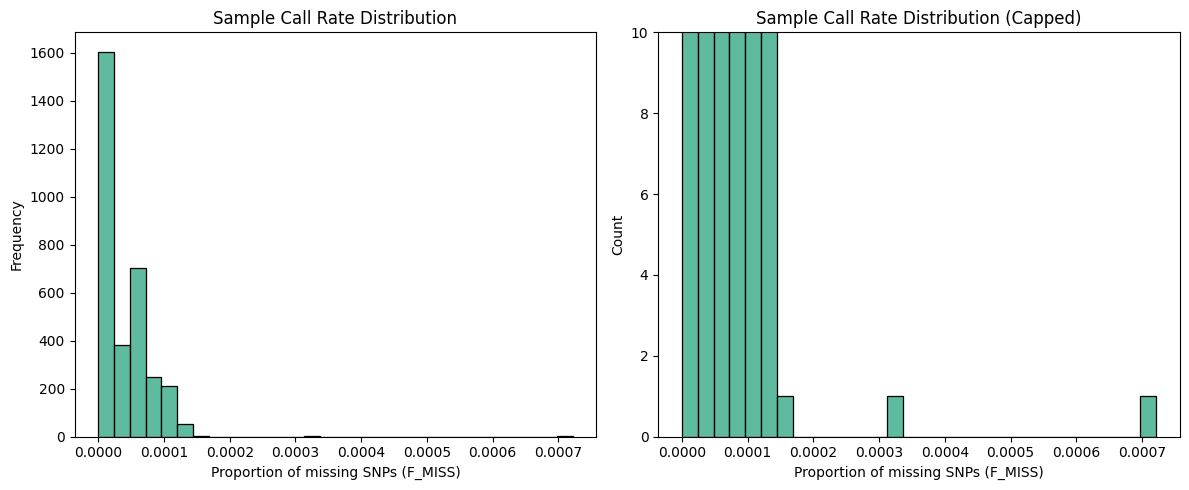

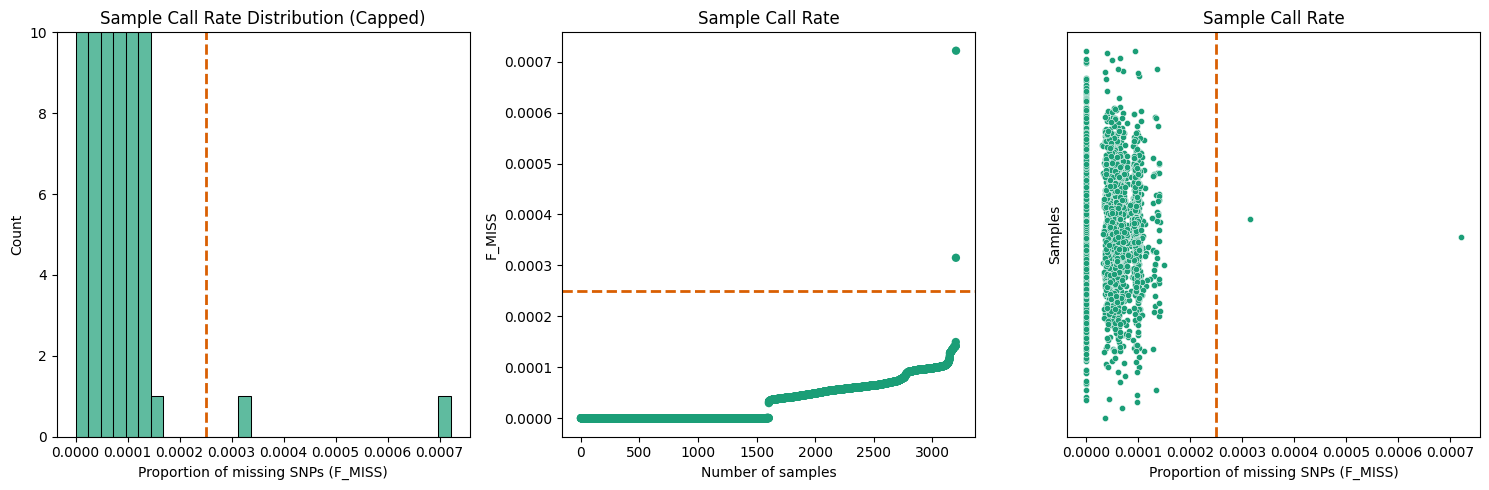

In [7]:
fail_call_rate = sample_qc.report_call_rate(
            file_path    = sample_qc.results_dir / (sample_qc.input_name + '-missing.imiss'), #sample_qc.call_rate_miss, 
            threshold    =sample_params['mind'],
            plots_dir    =sample_qc.plots_dir, 
            y_axis_cap   =10,
            format='svg'
        )

Now, the samples failing sex check are collected and a plot is shown where the user can check the number of problematic samples.

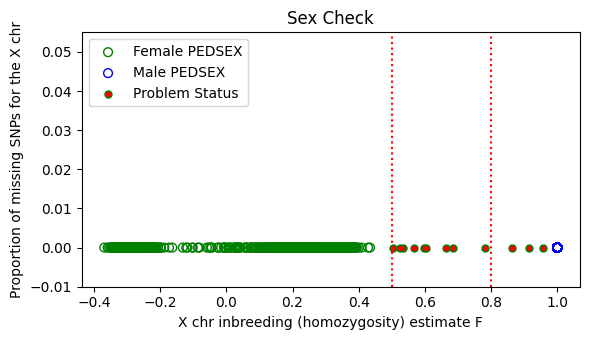

In [9]:
fail_sexcheck = sample_qc.report_sex_check(
            directory          =sample_qc.results_dir, 
            sex_check_filename =sample_qc.output_name+'-sexcheck.sexcheck', 
            xchr_imiss_filename=output_name+'-xchr-missing.imiss',
            f_coeff_thresholds=sample_params['sex_check'],
            plots_dir          =sample_qc.plots_dir,
            format='svg',
            fig_size=(6,3.5)
        )

Here a small dashboard with a report of the heterozigosity is shown. The cap on the Y-axis can be selected without re-running the whole pipeline, so it can be selected according to each user need. Moreover, the plots could help to choose a different deviation from the mean of the heterozigosity rate. Notice that the analysis has been divided for SNPs having a MAF of less than 1% and those above that threshold.

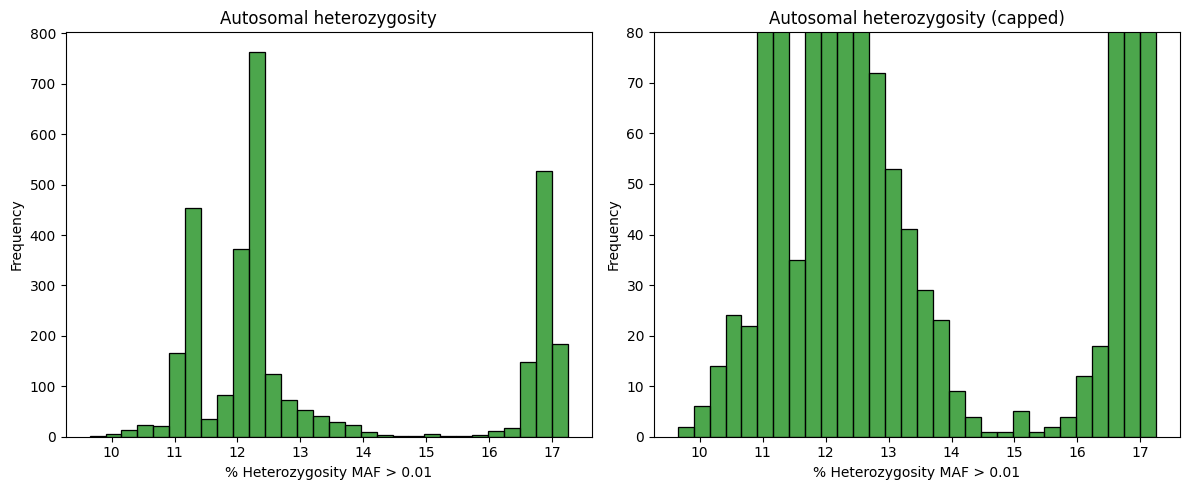

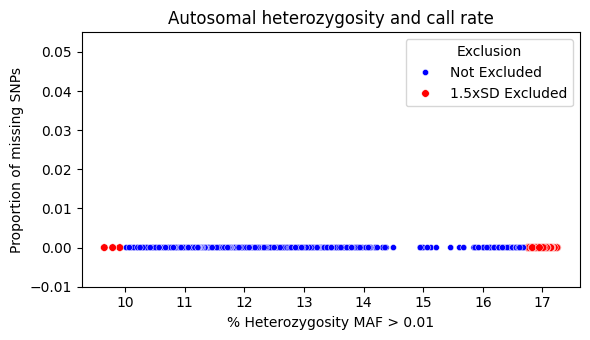

In [8]:
fail_het_greater = sample_qc.report_heterozygosity_rate(
            directory           = sample_qc.results_dir, 
            summary_ped_filename= 'Summary-'+sample_qc.output_name+'-chr1-22-mafgreater-recode.ped', 
            autosomal_filename  = sample_qc.output_name+'-chr1-22-mafgreater-missing.imiss', 
            std_deviation_het   = sample_params['het_deviation'],
            maf                 = sample_params['maf'],
            split               = '>',
            plots_dir           = sample_qc.plots_dir,
            format='svg',
            scatter_fig_size=(6, 3.5),
        )

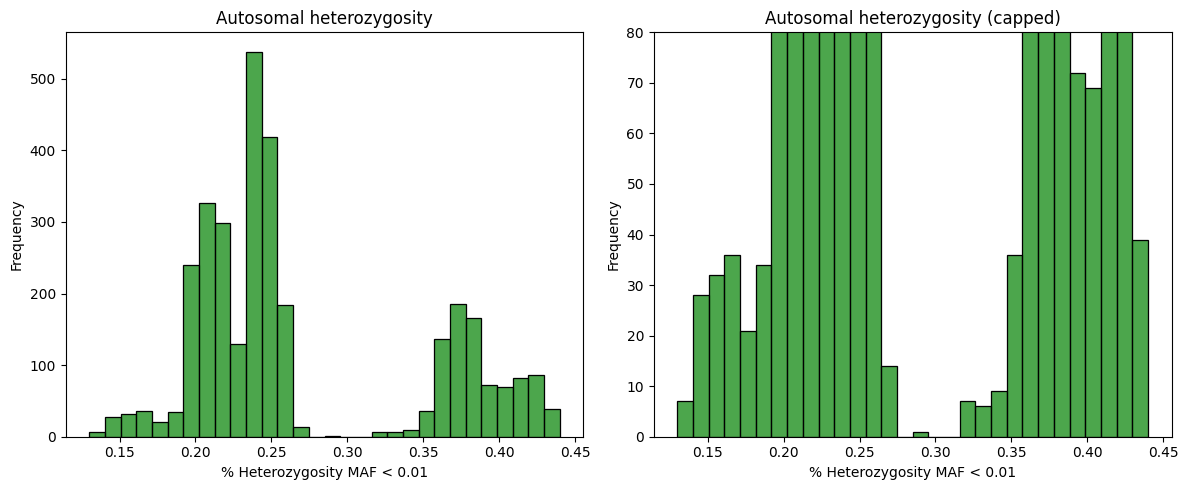

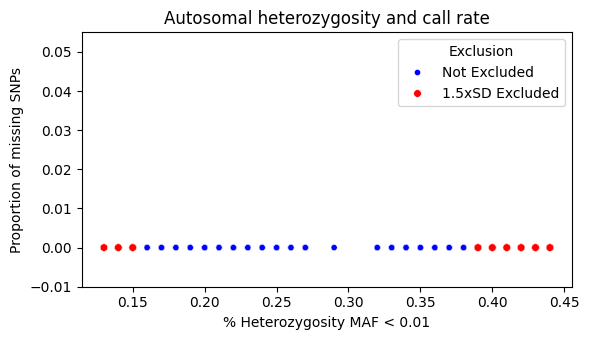

In [10]:
fail_het_gless= sample_qc.report_heterozygosity_rate(
            directory           = sample_qc.results_dir, 
            summary_ped_filename= 'Summary-'+sample_qc.output_name+'-chr1-22-mafless-recode.ped', 
            autosomal_filename  = sample_qc.output_name+'-chr1-22-mafless-missing.imiss', 
            std_deviation_het   = sample_params['het_deviation'],
            maf                 = sample_params['maf'],
            split               = '<',
            plots_dir           = sample_qc.plots_dir,
            format='svg',
            scatter_fig_size=(6, 3.5)
        )

In [ ]:

if sample_qc.use_king:
    fail_dup_relatednes = pd.read_csv(
                sample_qc.kinship_miss,
                sep=r'\s+',
                engine='python'
            )

    # filter samples that failed duplicates and relatedness check
    fail_dup_relatednes.columns = ['FID', 'IID']
    fail_dup_relatednes['Failure'] = 'Duplicates and relatedness'

In [ ]:
if not sample_params['use_kingship']:

    sample_qc.use_king = False

    fail_dup_relatednes = sample_qc.report_ibd_analysis(ibd_threshold=0.185)

    fail_dup_relatednes

All failing samples are collected and concatenated in a single pandas DataFrame and saved. A summary of the amount of samples failing each step is shown. 

In [ ]:
df_fails = pd.concat(
    [fail_call_rate, fail_sexcheck, fail_het_greater, fail_het_gless, fail_dup_relatednes],
    ignore_index=True
)

total_fails = df_fails.shape[0]
duplicates = df_fails.duplicated(subset=['FID', 'IID']).sum()
summary = df_fails['Failure'].value_counts().reset_index()

df_fails = df_fails.drop_duplicates(subset=['FID', 'IID'])

df_fails.to_csv(
    os.path.join(sample_qc.fails_dir, 'fail_samples.txt'), sep='\t',
    index=False
)

In [ ]:
summary

In [ ]:
print('Total samples failing QC: ', total_fails)
print('Number of duplicated samples: ', duplicates)
print('Unique samples failing QC: ', total_fails-duplicates)

Finally, the failing samples are dropped and cleaned `PLINK` files are generated.

In [ ]:
sample_qc.execute_drop_samples()

Some intermediate files are deleted to save space.

In [ ]:
sample_qc.clean_input_folder()
sample_qc.clean_result_folder()